## Model definition

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logsumexp
import itertools
import pandas as pd
from tqdm import tqdm

In [2]:
T = 40 # number of time steps
N = 2 # observation dim
K = 5 # latent dim
select_A = False

# latent state and observation
z = np.zeros(T).astype('int')
prob_z = np.zeros((T, K))
y = np.zeros((T, N))

# model parameters
A = np.random.randn(K, N, N)
b = np.random.randn(K, N)
Q = np.stack([0.2*np.eye(N, N) for i in range(K)])

# to be sure that linear system A_k does not point to infinity (not working)
if select_A:
    for k in range(K):
        a_eigw, a_eigv = np.linalg.eig(A[k])
        while((a_eigw.real > 0).any()):
            A[k] = np.random.randn(N, N)
            a_eigw, a_eigv = np.linalg.eig(A[k])

# augmented matrix [b, A]
A_hat = np.zeros((K, N, N+1))
for k in range(K):
    A_hat[k] = np.concatenate((b[k].reshape(N,1), A[k]), axis = 1)

# markovian transition matrix
# each row must sum to 1
M = np.stack([np.random.dirichlet(tuple([1]*K)) for i in range(K)])

# stationary distribution of prob_z
eigw, eigv = np.linalg.eig(M.T)
print(eigv.real[:, 0]/np.sum(eigv.real[:, 0]))

'''
# fixed points of the linear dynamics
x_star = np.stack([np.dot(np.linalg.inv(np.eye(N, N) - A[k]), b[k]) for k in range(K)])
'''

[0.09878751 0.30209985 0.16288182 0.26926292 0.16696791]


'\n# fixed points of the linear dynamics\nx_star = np.stack([np.dot(np.linalg.inv(np.eye(N, N) - A[k]), b[k]) for k in range(K)])\n'

## Visualizing linear dynamical systems

In [11]:
def plot_latent_state_dynamic(X1, X2, A, b):
    ###
    # plot vector fields given by A_k and b_k in the observation space
    ###
    
    n = X1.shape[0]
    X = np.stack([X1, X2])
    
    U = np.zeros((K, n, n))
    V = np.zeros((K, n, n))
    
    for k in range(K):
        for i in range(n):
            for j in range(n):
                U[k, i, j] = np.dot(A[k], X[:, i, j].reshape(-1, 2, 1))[0] + b[k, 0] - X[0, i, j]
                V[k, i, j] = np.dot(A[k], X[:, i, j].reshape(-1, 2, 1))[1] + b[k, 1] - X[1, i, j]
    
    fig, ax = plt.subplots(nrows = K, ncols = 1, figsize = (10, 8*K))
    for k in range(K):
        y_star = np.dot(np.linalg.inv(np.eye(N, N) - A[k]), b[k])
        ax[k].quiver(X1, X2, U[k], V[k], width = 0.0025)
        ax[k].scatter(y_star[0], y_star[1], label = "fixed point")
        ax[k].set_xlabel(r"$y_1$", fontsize = 15)
        ax[k].set_ylabel(r"$y_2$", fontsize = 15)
        ax[k].set_title(r"LDS with $k = {}$".format(k+1), fontsize = 15)
        ax[k].legend(loc = 'upper left')

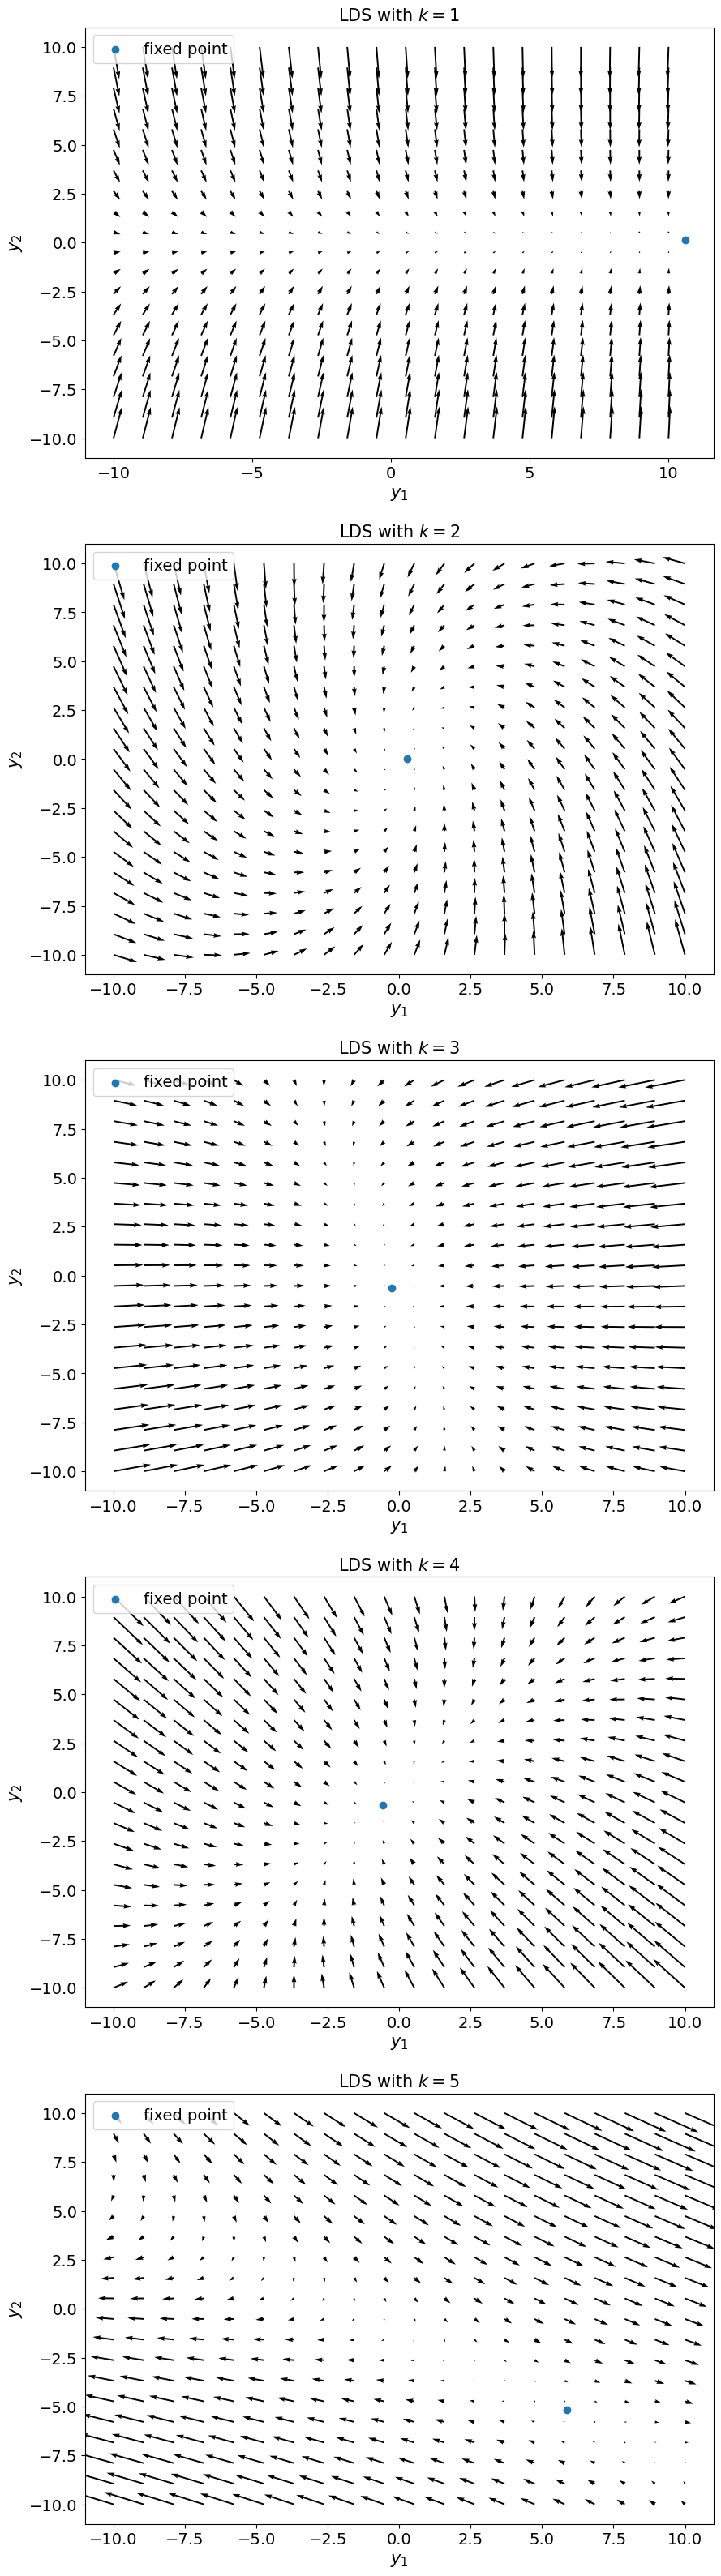

In [12]:
# create a grid just to display the dynamic systems
x1, x2 = np.linspace(-10,10,20), np.linspace(-10,10,20)
X1, X2 = np.meshgrid(x1, x2)

plot_latent_state_dynamic(X1, X2, A, b)

## Model simulation

In [13]:
# initial conditions
z[0] = int(np.random.randint(K)) # random number from 0 to K-1
prob_z[0, z[0]] = 1 # set the state probabilities to [0,0,...,1,...,0]
y[0] = np.random.randn(N) # start with random point in observation space

# time evolution of the dynamic system
for t in range(1,T):
    
    prob_z[t] = np.dot(prob_z[t-1].T, M).T # NOT USED ANYMORE
    z[t] = int(np.random.choice(K, p = M[z[t-1]]))
    nu = np.random.multivariate_normal(np.zeros(N), Q[z[t]])
    y[t] = np.dot(A[z[t]], y[t-1]) + b[z[t]] + nu

In [16]:
print(M)
print(z)
print(np.max(np.abs(y))) # check if it's too large, in that case resample the model parameters

[[0.37806007 0.04787885 0.0215324  0.25095492 0.30157376]
 [0.04462033 0.18140932 0.3555238  0.29338937 0.12505718]
 [0.19533624 0.3644519  0.07693068 0.30543258 0.0578486 ]
 [0.04243075 0.54580448 0.14161558 0.09171046 0.17843872]
 [0.02825903 0.2170405  0.01610227 0.48748998 0.25110821]]
[3 1 2 0 4 0 0 3 1 0 1 1 4 2 3 2 0 3 1 0 4 4 3 1 3 1 2 3 1 2 4 1 1 2 0 3 1
 2 3 1]
4.829960645039865


Text(0.5, 1.0, 'Observation space')

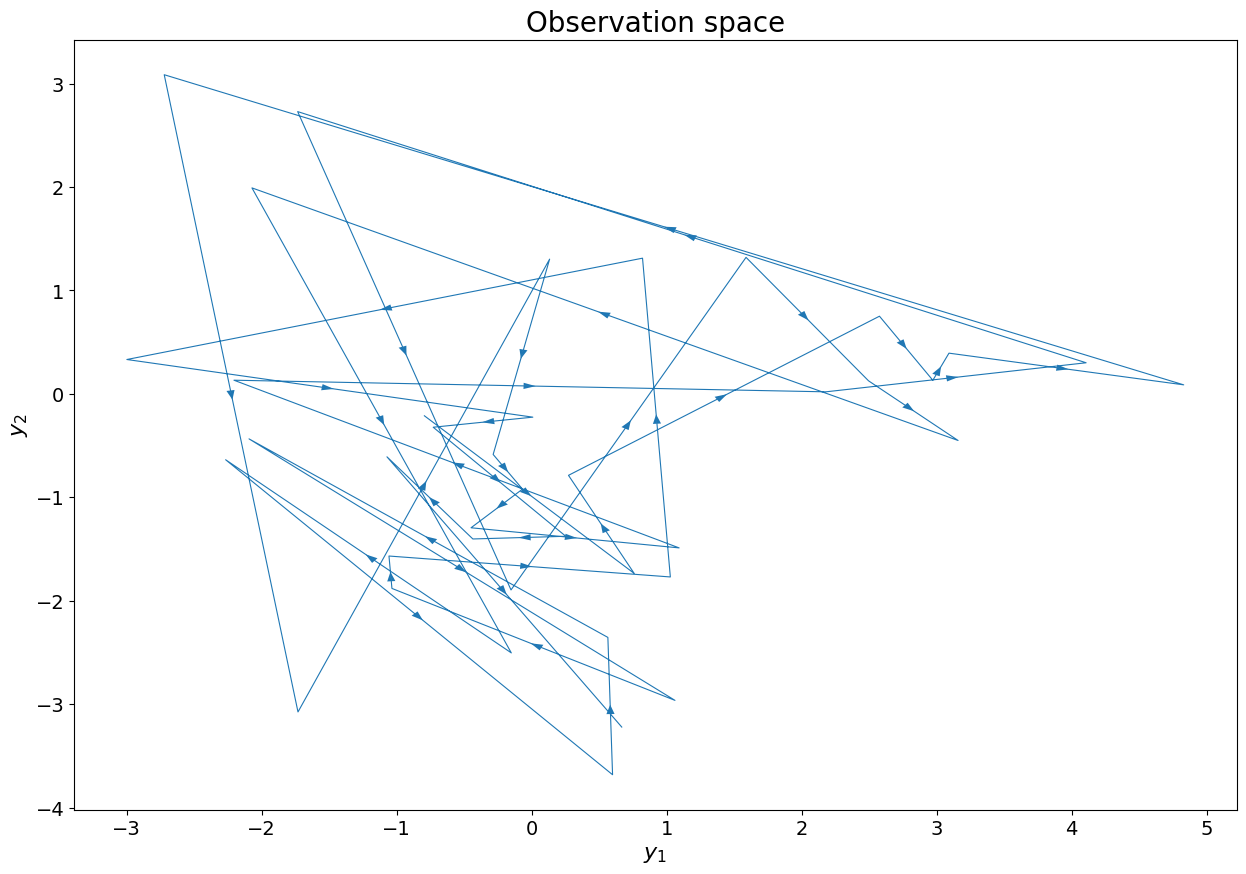

In [17]:
plt.rcParams.update({'font.size': 14})

plt.rcParams["figure.figsize"] = (15,10)

plt.plot(y[:, 0], y[:, 1], lw = 0.8)

# code to add the arrows in the middle of the lines (fix head_width if needed)
for t in range(T-1):
    arr_mean_y1 = np.mean([y[t, 0], y[t+1, 0]])
    arr_mean_y2 = np.mean([y[t, 1], y[t+1, 1]])
    dy1 = y[t+1, 0] - y[t, 0]
    dy2 = y[t+1, 1] - y[t, 1]
    plt.arrow(arr_mean_y1, arr_mean_y2, 0.01*dy1, 0.01*dy2, shape='full', lw=0, length_includes_head=True, head_width=np.max(np.abs(y))/80)
    
plt.xlabel(r"$y_1$", fontsize = 16)
plt.ylabel(r"$y_2$", fontsize = 16)
plt.title("Observation space", fontsize = 20)

## Inference

In [18]:
# to generate a random semipositive matrix
def generate_random_semipositive_matrix(dim, scale):

    tm = np.random.randn(dim, dim)
    test_matrix = scale*np.dot(tm, tm.T)
    
    return test_matrix

In [19]:
from scipy.stats import multivariate_normal, invwishart, matrix_normal

L = 200 # how many Gibbs iteration to do
N = 2
### PRIORS

# IW(Q_k| S, nu)
# MN(A_hat_k| C, Q_k, V)

precision = 0.2 # scale of the expected data variability
S = precision*np.eye(N, N)
nu = N

C = np.zeros((N, N+1))
C[:, 0] = np.zeros(N)
C[:, 1:] = np.eye(N, N)
V = np.eye(N+1, N+1)

### INFERRED VARIABLES

# inferred samples of z
z_inf = np.zeros((L,T)).astype('int')
z_inf[0] = np.random.randint(K, size = T).astype('int')

# inferred samples of M
M_inf = np.zeros((L,K,K))
M_inf[0] = np.stack([np.random.dirichlet(tuple([1]*K)) for i in range(K)])

# inferred samples of A_hat
A_hat_inf = np.zeros((L, K, N, N+1))
A_hat_inf[0] = np.random.randn(K, N, N+1)

# inferred samples of Q_k
Q_inf = np.zeros((L,K,N,N))
Q_inf[0] = np.stack([generate_random_semipositive_matrix(N, 1) for k in range(K)])

# inferred alpha parameters for the conditional dirichlet (to sample M)
alpha_inf = np.ones((L,K,K))

In [20]:
print(S)
print(C)
print(V)

[[0.2 0. ]
 [0.  0.2]]
[[0. 1. 0.]
 [0. 0. 1.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [21]:
### version of sampling z from Stefano

def myconditionals(M_inf_l, A_hat_inf_l, Q_inf_l, z_inf_prec):

    # discrete conditional distribution P(z_t|...) at each time 1,...,T
    p_z = np.zeros((T, K))
    log_p_z = np.zeros((T, K))
    z_inf_l = np.zeros(T).astype('int')

    # P(z_1|...)
    for k in range(K):
        log_p_z[0, k] = np.log(M_inf_l[z_inf_prec[1], k])
    log_p_z[0] = log_p_z[0] - logsumexp(log_p_z[0])
    z_inf_l[0] = np.random.choice(K, p = np.exp(log_p_z[0]))

    # P(z_t|...) for t in 2:T-1
    for t in range(1, T-1):
        for k in range(K):
            y_hat = np.concatenate([np.array([1]), y[t-1]])
            rv = multivariate_normal(np.zeros(N), Q_inf_l[k])
            x = y[t] - np.dot(A_hat_inf_l[k], y_hat)
            log_p_z[t, k] = rv.logpdf(x) + np.log(M_inf_l[z_inf_prec[t+1], k] * M_inf_l[k, z_inf_l[t-1]])
            #print(rv.pdf(x))

        log_p_z[t] = log_p_z[t] - logsumexp(log_p_z[t])
        z_inf_l[t] = np.random.choice(K, p = np.exp(log_p_z[t]))

    # P(z_T|...)        
    for k in range(K):
        y_hat = np.concatenate([np.array([1]), y[T-2]])
        rv = multivariate_normal(np.zeros(N), Q_inf_l[k])
        x = y[T-1] - np.dot(A_hat_inf_l[k], y_hat)
        log_p_z[T-1, k] = rv.logpdf(x) + np.log(M_inf_l[k, z_inf_l[T-2]])
    log_p_z[T-1] = log_p_z[T-1] - logsumexp(log_p_z[T-1])
    z_inf_l[T-1] = np.random.choice(K, p = np.exp(log_p_z[T-1]))

    return z_inf_l


In [22]:
### function to try to implement forward-backward algo

def message_passing(M_inf_l, A_hat_inf_l, Q_inf_l):

    log_m = [np.array([0]*K)] # list of log messages, the first one has all zeros

    for t in reversed(range(1,T)): # T-1, T-2, ...
        y_hat = np.concatenate([np.array([1]), y[t-1]])
        somm = np.zeros((K, K))
        m_t = np.zeros(K) # log of message at time t
        for k in range(K):
            for j in range(K):
                rv = multivariate_normal(np.zeros(N), Q_inf_l[j])
                x = y[t] - np.dot(A_hat_inf_l[j], y_hat)
                somm[k,j] = np.log(M_inf_l[k,j]) + rv.logpdf(x) + log_m[T-1-t][j]

            m_t[k] = logsumexp(somm[k])
        
        log_m.append(m_t) # insert message in the list

    log_p_z = np.zeros((T, K))
    z_inf_l = np.zeros(T).astype('int')

    # sampling z_1
    for k in range(K):
        log_p_z[0, k] = log_m[T-1][k]
    log_p_z[0] = log_p_z[0] - logsumexp(log_p_z[0])
    z_inf_l[0] = np.random.choice(K, p = np.exp(log_p_z[0]))

    # sampling all the other z_t
    for t in range(1,T):
        y_hat = np.concatenate([np.array([1]), y[t-1]])
        for k in range(K):
            rv = multivariate_normal(np.zeros(N), Q_inf_l[k])
            x = y[t] - np.dot(A_hat_inf_l[k], y_hat)
            log_p_z[t, k] = np.log(M_inf_l[z_inf_l[t-1],k]) + rv.logpdf(x) + log_m[T-1-t][k]
        log_p_z[t] = log_p_z[t] - logsumexp(log_p_z[t])
        z_inf_l[t] = np.random.choice(K, p = np.exp(log_p_z[t]))

    return z_inf_l

In [23]:
### Gibbs sampling loop, update in sequence: z, M, A_hat, Q

for l in tqdm(range(L-1)):
    
    #print("\n SAMPLE:", l)
    
    ### UPDATE z_t

    z_inf[l+1] = message_passing(M_inf[l], A_hat_inf[l], Q_inf[l])
    #z_inf[l+1] = myconditionals(M_inf[l], A_hat_inf[l], Q_inf[l], z_inf[l])

    ## UPDATE M
    
    # computing how many times there is a transition from state k to state j
    chi = np.zeros((K, K))
    
    for k in range(K):
        for j in range(K):
            somm = 0
            for t in range(T-1):
                if z_inf[l+1, t] == k and z_inf[l+1, t+1] == j:
                    somm += 1
            chi[k, j] = somm
    
    # updating conditional dirichlet parameters alpha initially set to [1,1,...,1]
    alpha_inf[l+1] += chi
    
    # sampling rows of M from conditional distribution P(M|alpha)
    for k in range(K):
        M_inf[l+1, k] = np.random.dirichlet(tuple(alpha_inf[l+1, k]))
    
    ### UPDATE MODEL PARAMETERS (see overleaf)
    
    # create data matrix grouped by state, all y_t where z_t = k
    Y = [[] for k in range(K)]

    # create data matrix grouped by state, all y_{t-1} where z_t = k
    Y_bar = [[] for k in range(K)]

    # number of observations belonging to a given state k
    N_k = np.zeros(K)
    
    for k in range(K):
        for t in range(1, T):
            if z_inf[l+1, t] == k:
                Y[k].append(y[t])
                Y_bar[k].append(np.concatenate([np.array([1]), y[t-1]]))
    
        N_k[k] = len(Y[k])
        #print(N_k[k])
        if N_k[k] != 0:
            Y[k] = np.stack(Y[k]).T
            Y_bar[k] = np.stack(Y_bar[k]).T
        
    # sufficient statistics for MNIW (see overleaf)
    
    S_ybar_ybar = np.zeros((K, N+1, N+1))
    S_y_ybar = np.zeros((K, N, N+1))
    S_y_y = np.zeros((K, N, N))
    S_y_given_ybar = np.zeros((K, N, N))
    
    for k in range(K):
        if N_k[k] != 0:
            #print(Y_bar[k].shape)
            S_ybar_ybar[k] = np.dot(Y_bar[k], Y_bar[k].T) + V
            S_y_ybar[k] = np.dot(Y[k], Y_bar[k].T) + np.dot(C, V)
            S_y_y[k] = np.dot(Y[k], Y[k].T) + C @ V @ C.T
            S_y_given_ybar[k] = S_y_y[k] - S_y_ybar[k] @ np.linalg.inv(S_ybar_ybar[k]) @ S_y_ybar[k].T
    
    # sampling from IW and MN with updated hyperparameters
    
    for k in range(K):
        if N_k[k] != 0:
            rv_iw = invwishart(nu + N_k[k], S + S_y_given_ybar[k])
            Q_inf[l+1, k] = rv_iw.rvs(size = 1)
            
            # INVERSE OF Q OR NOT?
            rv_mn = matrix_normal(S_y_ybar[k] @ np.linalg.inv(S_ybar_ybar[k]), Q_inf[l+1, k], np.linalg.inv(S_ybar_ybar[k]))
            A_hat_inf[l+1, k] = rv_mn.rvs(size = 1)
        else:
            # keep the same o sample a fresh new?
            # not that much difference, because in this case all states tend to be used,
            # so is rare to come inside here

            '''
            Q_inf[l+1, k] = Q_inf[l, k]
            A_hat_inf[l+1, k] = A_hat_inf[l, k]
            '''
            rv_iw = invwishart(nu, S)
            Q_inf[l+1, k] = rv_iw.rvs(size = 1)
            rv_mn = matrix_normal(C, Q_inf[l+1, k], V)
            A_hat_inf[l+1, k] = rv_mn.rvs(size = 1)

100%|██████████| 199/199 [01:25<00:00,  2.33it/s]


In [24]:
# comparing true z and inferred ones from gibbs sampler
print(z)
print(z_inf[0])
print(z_inf[1])
print(z_inf[-1])

[3 1 2 0 4 0 0 3 1 0 1 1 4 2 3 2 0 3 1 0 4 4 3 1 3 1 2 3 1 2 4 1 1 2 0 3 1
 2 3 1]
[4 3 1 2 0 2 3 1 2 3 3 4 4 0 2 0 1 4 3 2 2 1 4 0 3 4 3 3 4 4 2 1 3 2 3 3 1
 3 1 2]
[4 2 1 1 3 1 1 2 1 1 0 3 2 1 2 1 1 2 4 1 3 1 2 4 2 2 1 2 2 1 2 3 1 4 2 2 3
 2 3 2]
[3 4 1 3 3 0 3 2 4 3 3 0 0 4 2 1 3 2 4 3 3 3 2 4 2 4 1 2 4 1 2 4 4 1 2 1 4
 1 2 4]


### Find the right permutation

In [25]:
def compare_params(A_hat_true, A_hat_sample):
    # evaluate the best permutation of labels that gives the best match between 
    # real lds and inferred one
    perm = np.zeros(K).astype('int')
    distance = np.zeros((K, K)) # matrix of Frobenius distances
    for k in range(K):
        for j in range(K):
            distance[k, j] = np.linalg.norm(A_hat_sample[k] - A_hat_true[j])
    dist = np.copy(distance)
    for k in range(K): # loop to sequentially assign labels starting from the pair with less distance
        min_dist_idx = np.unravel_index(dist.argmin(), dist.shape)
        perm[min_dist_idx[0]] = min_dist_idx[1]
        dist[min_dist_idx[0], :] = np.inf
        dist[:, min_dist_idx[1]] = np.inf

    return distance, perm

def permute_states(best_perm, inferred_z):
    # permute labels of inferred_z with the best_perm combination
    inferred_labels =  list(set(inferred_z))
    B = dict(zip(inferred_labels, tuple(best_perm)))
    C = ((pd.Series(inferred_z)).map(B)).to_list()
    return C

def hamming_distance(a_list, b_list):
    # how similar are two lists
    dist = sum(b_list == a_list)/len(a_list)
    return dist

def permute_M(inv_perm, inferred_M):
    # permute labels of inferred_M, given the inverse permutation map
    inferred_M = inferred_M[inv_perm, :]
    inferred_M = inferred_M[:, inv_perm]
    return inferred_M

def compute_mean_z(inferred_z):
    # mean_z of a certain number of samples, following majority rule
    mean_z = np.zeros(T).astype('int')
    for t in range(T):
        mean_z[t] = np.argmax(np.bincount(inferred_z[:, t]))
    return mean_z

### Create Hamming distance plot

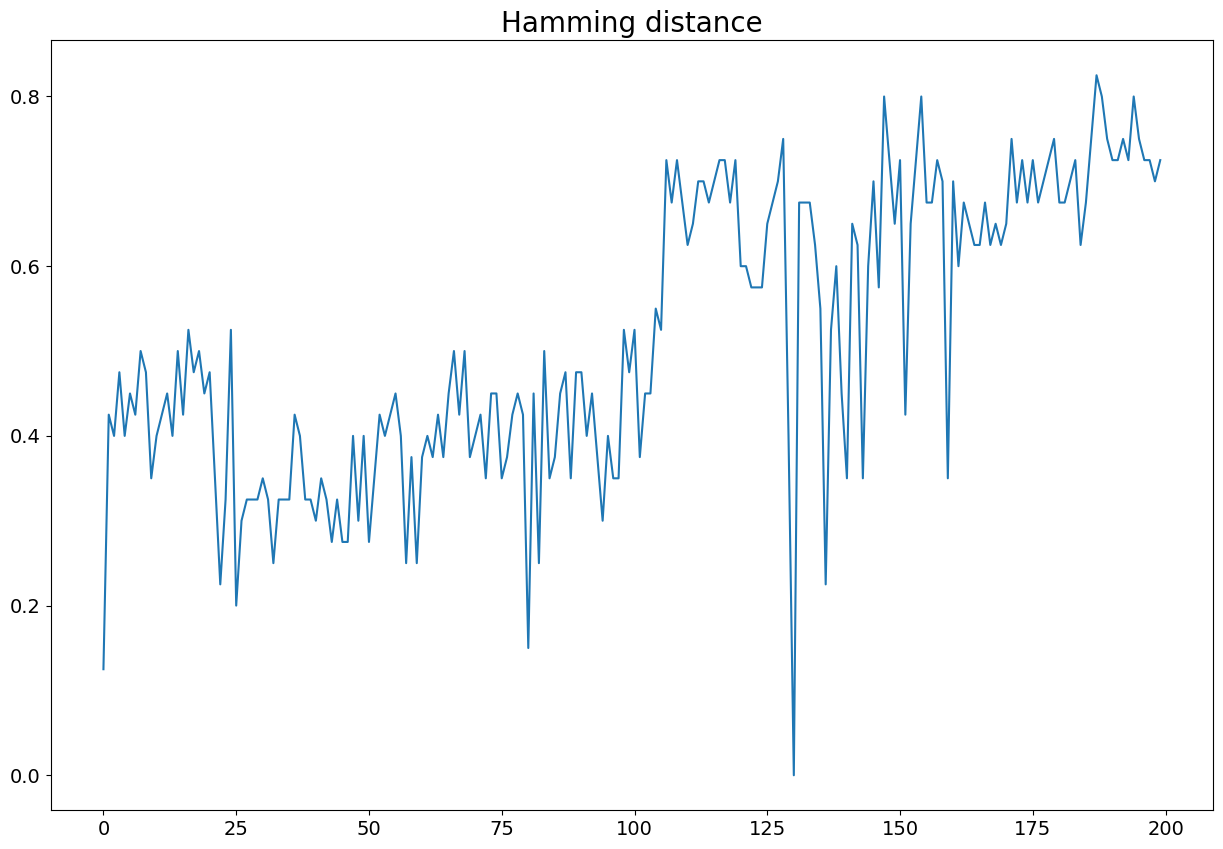

In [26]:
hamm_dist = np.zeros(L)
for l in range(L):
    _, perm = compare_params(A_hat, A_hat_inf[l])
    z_inf_perm = permute_states(perm, z_inf[l])
    hamm_dist[l] = hamming_distance(z_inf_perm, z)
plt.title("Hamming distance", fontsize = 20)
plt.plot(range(L), hamm_dist)

In [27]:
### What is the best estimation for model parameters? The mean of the gibbs samples or only the last one?

A_hat_mean = np.mean(A_hat_inf[L//2:], axis = 0) # best estimate for A_hat
_, best_perm = compare_params(A_hat, A_hat_mean) # compare true and inferred A_hat to retrieve best permutation of labels
print(best_perm)

# compute inverse permutation (needed later)
inv_perm = np.zeros(K).astype('int')
for k in range(K):
    inv_perm[best_perm[k]] = k

print(inv_perm)

[4 2 3 0 1]
[3 4 1 2 0]


In [28]:
z_mean = compute_mean_z(z_inf[L//2:]) # best estimate for z
z_inf_perm = permute_states(best_perm, z_mean) # fixing labels
print(list(z))
print(z_inf_perm)
print(hamming_distance(z_inf_perm, z))

[3, 1, 2, 0, 4, 0, 0, 3, 1, 0, 1, 1, 4, 2, 3, 2, 0, 3, 1, 0, 4, 4, 3, 1, 3, 1, 2, 3, 1, 2, 4, 1, 1, 2, 0, 3, 1, 2, 3, 1]
[3, 1, 1, 0, 4, 4, 0, 3, 1, 0, 0, 3, 1, 1, 3, 2, 0, 3, 1, 0, 0, 0, 3, 1, 3, 1, 2, 3, 1, 2, 3, 1, 1, 1, 2, 3, 1, 2, 3, 1]
0.725


In [29]:
M_mean = np.mean(M_inf[L//2:], axis = 0) # best estimate for M
M_inf_perm = permute_M(inv_perm, M_mean) # fixing labels
print(M)
print(M_inf_perm)
print(np.linalg.norm(M_inf_perm - M)) # Frobenius distance of the two matrices

[[0.37806007 0.04787885 0.0215324  0.25095492 0.30157376]
 [0.04462033 0.18140932 0.3555238  0.29338937 0.12505718]
 [0.19533624 0.3644519  0.07693068 0.30543258 0.0578486 ]
 [0.04243075 0.54580448 0.14161558 0.09171046 0.17843872]
 [0.02825903 0.2170405  0.01610227 0.48748998 0.25110821]]
[[0.29123842 0.10945843 0.09174398 0.3209598  0.18659936]
 [0.22851359 0.18519107 0.26715931 0.20406871 0.11506733]
 [0.20324135 0.17058086 0.16191618 0.35922879 0.10503282]
 [0.09428084 0.59112088 0.12906691 0.10470381 0.08082755]
 [0.24107905 0.15718016 0.20205117 0.22695367 0.17273595]]
0.5533158542004429


In [30]:
A_hat_mean = A_hat_mean[inv_perm] # fixing labels
print(A_hat)
print(A_hat_mean)

[[[ 1.89455924  0.82201285 -0.07069497]
  [-0.01735241  0.02259583 -0.65150296]]

 [[ 0.27056691  0.00278456 -0.37920589]
  [-0.3149314   1.28013904  0.12691448]]

 [[-0.91792137 -1.26911749 -0.52899896]
  [-0.30219145 -0.07640653  0.55667735]]

 [[-0.52729622 -0.44431928  0.4807415 ]
  [-0.31761788  0.70415533 -0.11553358]]

 [[ 0.22601912  1.21952814  0.29171909]
  [-0.4130339  -0.05176419  0.86184802]]]
[[[ 1.17916391  1.05405727 -0.28957317]
  [ 0.30259404 -0.03222686 -0.27258342]]

 [[-0.0564067  -0.25255987 -0.49610917]
  [-0.67216406  1.1349622   0.27192838]]

 [[ 0.0434     -0.20763646 -0.0315861 ]
  [-0.18638939  0.03830946  0.62883909]]

 [[-0.53385566 -0.38507446  0.49099271]
  [-0.05759101  0.64374104  0.3506392 ]]

 [[ 0.02250689  1.05277578  0.10837355]
  [-0.00440981  0.03323836  0.73836025]]]


In [31]:
Q_mean = np.mean(Q_inf[L//2:], axis = 0) # best estimate for Q
Q_mean = Q_mean[inv_perm] # fixing labels
print(Q)
print(Q_mean)

[[[0.2 0. ]
  [0.  0.2]]

 [[0.2 0. ]
  [0.  0.2]]

 [[0.2 0. ]
  [0.  0.2]]

 [[0.2 0. ]
  [0.  0.2]]

 [[0.2 0. ]
  [0.  0.2]]]
[[[ 0.86453207  0.21307241]
  [ 0.21307241  0.46604121]]

 [[ 0.59022621 -0.04618988]
  [-0.04618988  0.55305479]]

 [[ 1.1230816   0.01076099]
  [ 0.01076099  0.18404037]]

 [[ 0.50463905 -0.20828381]
  [-0.20828381  0.27732248]]

 [[ 0.21822284 -0.05024501]
  [-0.05024501  0.41287796]]]


In [32]:
# best estimate for A_hat decomposition in A and b, in order to plot the lds
b_inf_av = A_hat_mean[:,:,0]
A_inf_av = A_hat_mean[:,:,1:]

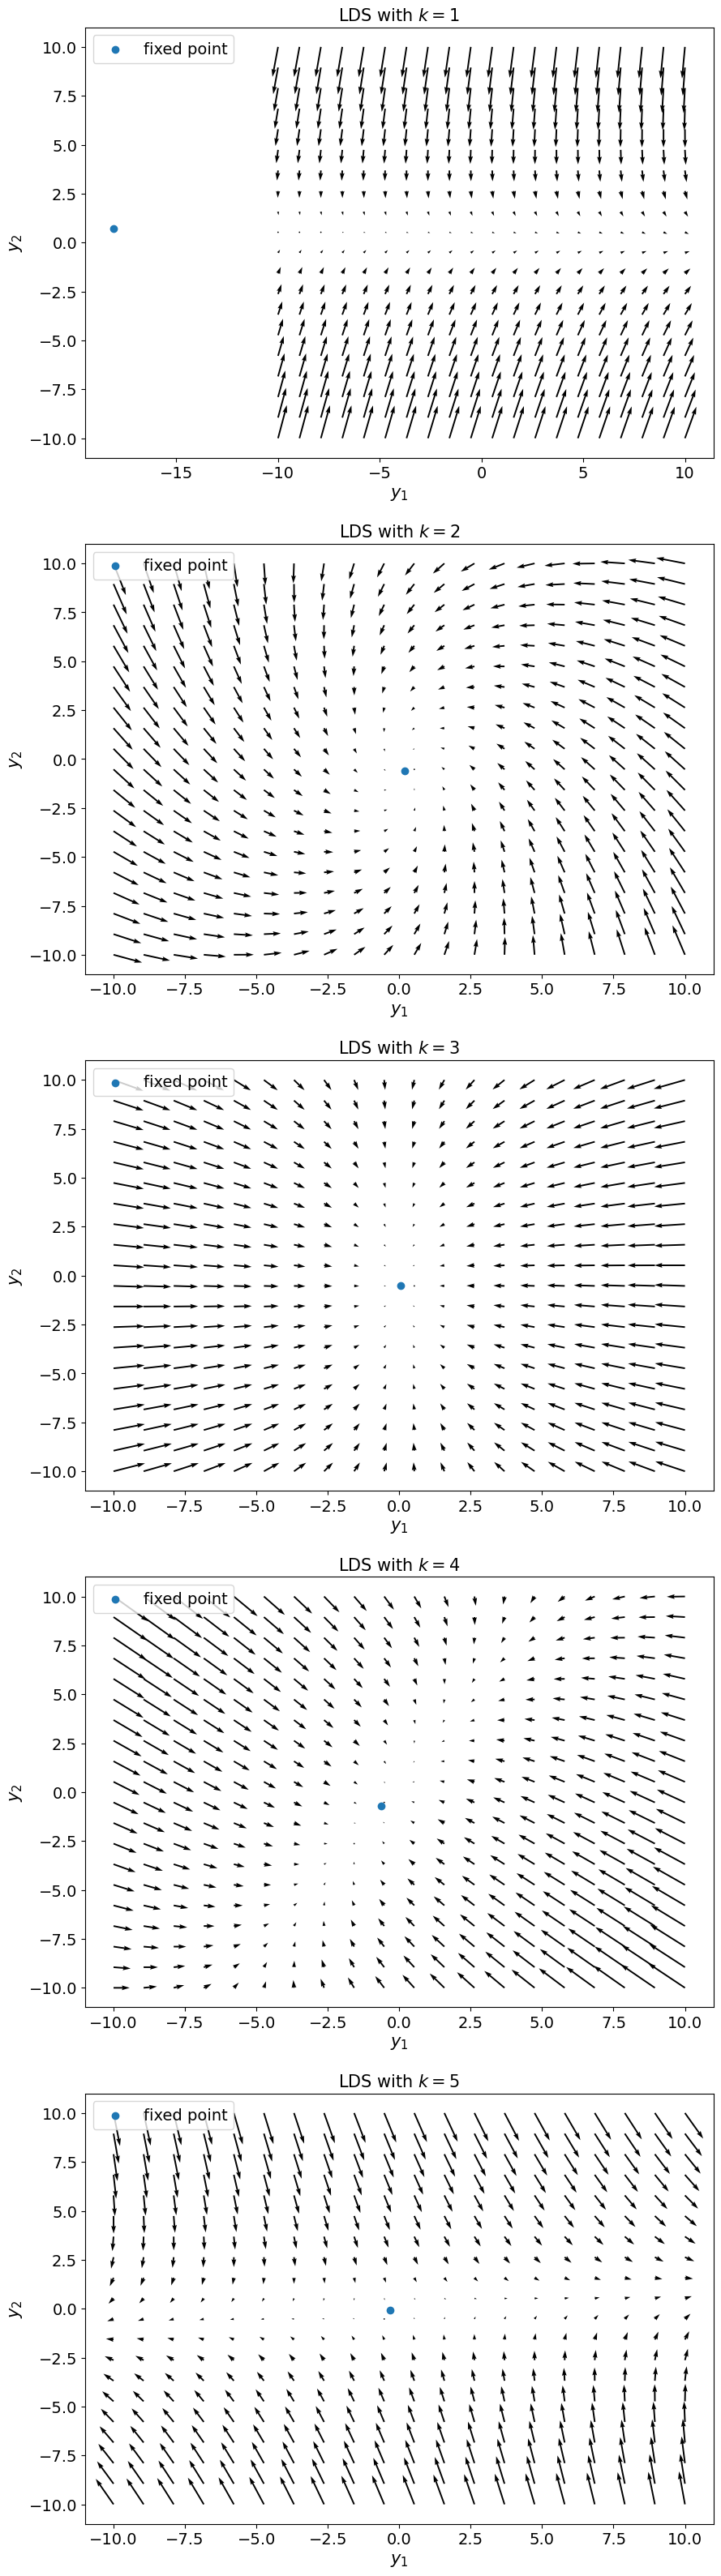

In [33]:
plot_latent_state_dynamic(X1, X2, A_inf_av, b_inf_av)

## Extra stuff

### Find the right permutation (way 1)

In [0]:
def Zscore(true_z, inferred_z):
    true_labels =  list(set(true_z))   
    inferred_labels =  list(set(inferred_z))
    score = 0
    D_best = []
    perm_best = ()
    for i in itertools.permutations(true_labels):
        A = inferred_z #list we want to replace with a dictionary lookup
        B = dict(zip( inferred_labels,i)) #dictionary lookup, dict values in B will be mapped to entries in A
        C = (pd.Series(A)).map(B) #convert the list to a pandas series temporarily before mapping
        D = list(C) # we transform the mapped values (a series object) back to a list
        temp_score = (sum(D == true_z)/len(true_z))
        if temp_score > score:
            score = temp_score
            D_best = D
            perm_best = B#i
    return D_best, perm_best, score

In [0]:
z_inf_perm, perm_map, score1 = Zscore(z, z_inf[-1])
print(list(z))
print(z_inf_perm)
print(score1)
print(perm_map)

### Understanding distributions

In [ ]:
np.random.dirichlet((200,100))

array([0.68027223, 0.31972777])

In [ ]:
rv_iw = invwishart(N, 0.2*S)
rand_q = rv_iw.rvs(size = 1)
eigw_q, _ = np.linalg.eig(rand_q)
print(rand_q)
print(eigw_q)

[[0.10502792 0.06191519]
 [0.06191519 0.16200628]]
[0.06536195 0.20167224]


In [ ]:
rv_mn = matrix_normal(np.array([[0,1,0],[0,0,1]]), 0.001*Q[0], 0.001*np.eye(N+1, N+1))
rand_a_hat = rv_mn.rvs(size = 1)
print(rand_a_hat)
# [[0,1,0],[0,0,1]]

[[-9.58508792e-05  9.99966230e-01  1.26777625e-04]
 [-2.70375259e-04 -1.42153609e-04  9.99988753e-01]]


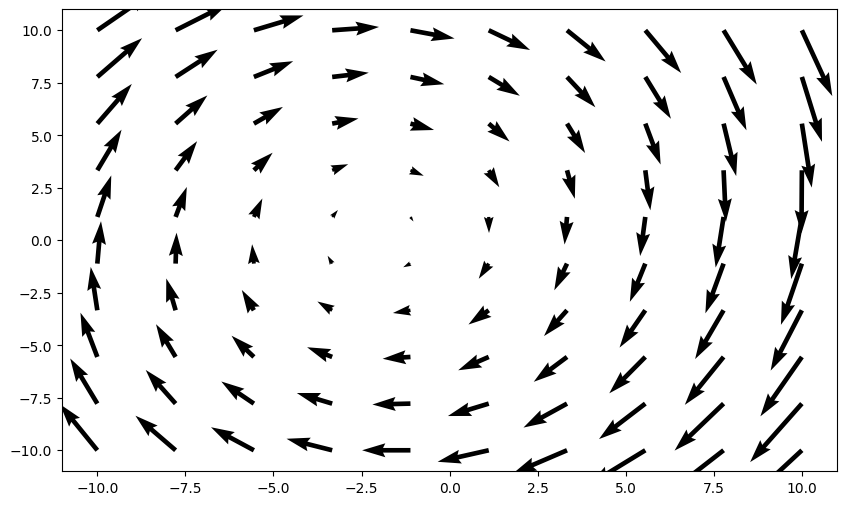

In [ ]:
x1, x2 = np.linspace(-10,10,10), np.linspace(-10,10,10)
X1, X2 = np.meshgrid(x1, x2)
rand_b = rand_a_hat[:,0]
rand_a = rand_a_hat[:,1:]

n = X1.shape[0]
X = np.stack([X1, X2])
    
U = np.zeros((n, n))
V = np.zeros((n, n))
    
for i in range(n):
    for j in range(n):
        U[i, j] = np.dot(rand_a, X[:, i, j].reshape(-1, 2, 1))[0] + rand_b[0] - X[0, i, j]
        V[i, j] = np.dot(rand_a, X[:, i, j].reshape(-1, 2, 1))[1] + rand_b[1] - X[1, i, j]
    
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 6))
ax.quiver(X1, X2, U, V)
#ax[0].scatter(x_star[k][0], x_star[k][1])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7418b957-40c0-4b8c-8b59-f82ba42a5a5a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>